# Modelo de Riesgo de Crédito

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import os
df = pd.read_csv(os.path.join('..', 'data', 'output', 'loan_cleaned.csv'))

# Identificar las características y la variable objetivo
target = 'target'  
numerical_features = df.select_dtypes(include=['float', 'int']).columns
categorical_features = df.select_dtypes(include=['object']).columns 
numerical_features = numerical_features.drop('target')

X = df.drop(columns=[target])
y = df[target]

In [6]:
# Imputación de valores faltantes
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Preprocesamiento de variables categóricas y numéricas
categorical_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
numerical_scaler = StandardScaler()

# Pipeline para preprocesamiento
preprocessor = ColumnTransformer([
    ('num', Pipeline(steps=[
        ('imputer', numerical_imputer),
        ('scaler', numerical_scaler)
    ]), numerical_features),
    ('cat', Pipeline(steps=[
        ('imputer', categorical_imputer),
        ('encoder', categorical_encoder)
    ]), categorical_features)
])


In [7]:
# Dividir en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Aplicar el preprocesamiento
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [8]:
# Definir el modelo
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
			loss='binary_crossentropy',
			metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50, 
                    batch_size=128, 
                    verbose=1)


Epoch 1/50
4190/4190 [==============================] - 8s 2ms/step - loss: 0.1210 - accuracy: 0.9696 - val_loss: 0.1049 - val_accuracy: 0.9738
Epoch 2/50
4190/4190 [==============================] - 7s 2ms/step - loss: 0.1091 - accuracy: 0.9730 - val_loss: 0.1042 - val_accuracy: 0.9738
Epoch 3/50
4190/4190 [==============================] - 7s 2ms/step - loss: 0.1078 - accuracy: 0.9732 - val_loss: 0.1040 - val_accuracy: 0.9739
Epoch 4/50
4190/4190 [==============================] - 7s 2ms/step - loss: 0.1071 - accuracy: 0.9733 - val_loss: 0.1040 - val_accuracy: 0.9738
Epoch 5/50
4190/4190 [==============================] - 7s 2ms/step - loss: 0.1065 - accuracy: 0.9733 - val_loss: 0.1033 - val_accuracy: 0.9744
Epoch 6/50
4190/4190 [==============================] - 7s 2ms/step - loss: 0.1061 - accuracy: 0.9734 - val_loss: 0.1037 - val_accuracy: 0.9740
Epoch 7/50
4190/4190 [==============================] - 7s 2ms/step - loss: 0.1058 - accuracy: 0.9734 - val_loss: 0.1037 - val_accuracy:

3592/3592 [==============================] - 2s 641us/step
AUC-ROC: 0.91


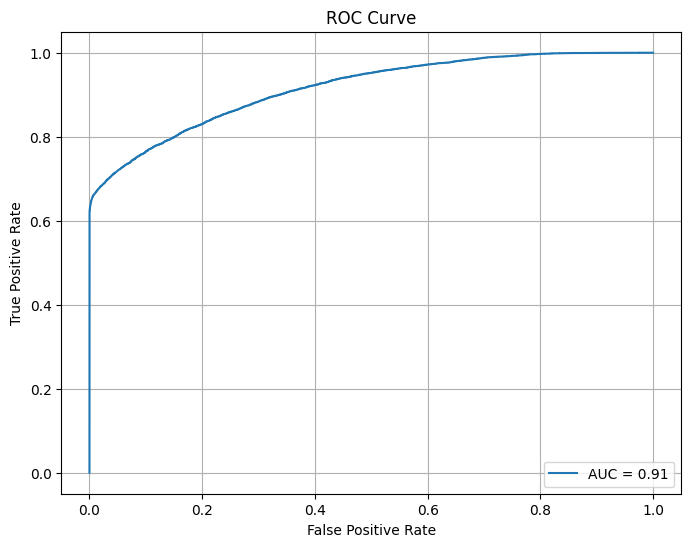

In [9]:
# Evaluar el modelo
y_pred_proba = model.predict(X_test).ravel()
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC-ROC: {auc_score:.2f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


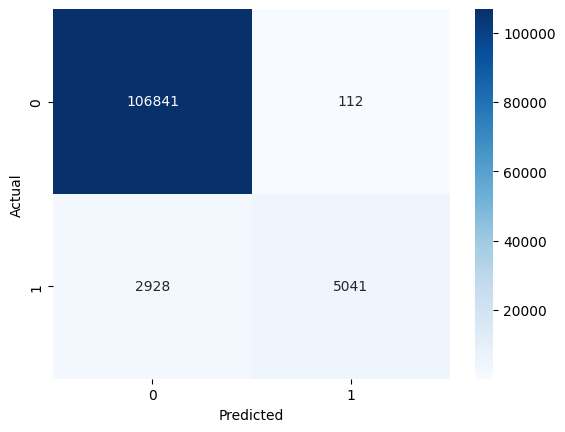

In [13]:
# Matriz de confusión
y_pred = (y_pred_proba > 0.5).astype(int)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

In [14]:
# Reporte de clasificación
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    106953
           1       0.98      0.63      0.77      7969

    accuracy                           0.97    114922
   macro avg       0.98      0.82      0.88    114922
weighted avg       0.97      0.97      0.97    114922



In [16]:
# Función para convertir probabilidades a puntajes
def probability_to_score(prob, base_score=600, pdo=50):
    odds = (1 - prob) / prob
    factor = pdo / np.log(2)
    offset = base_score - factor * np.log(20)  # Odds iniciales de 20:1
    score = offset - factor * np.log(odds)
    return score

# Convertir probabilidades a puntajes
y_scores = np.array([probability_to_score(p) for p in y_pred_proba])

C:\Users\alexg\AppData\Local\Temp\ipykernel_26460\1537970650.py:6: RuntimeWarning: divide by zero encountered in log
  score = offset - factor * np.log(odds)


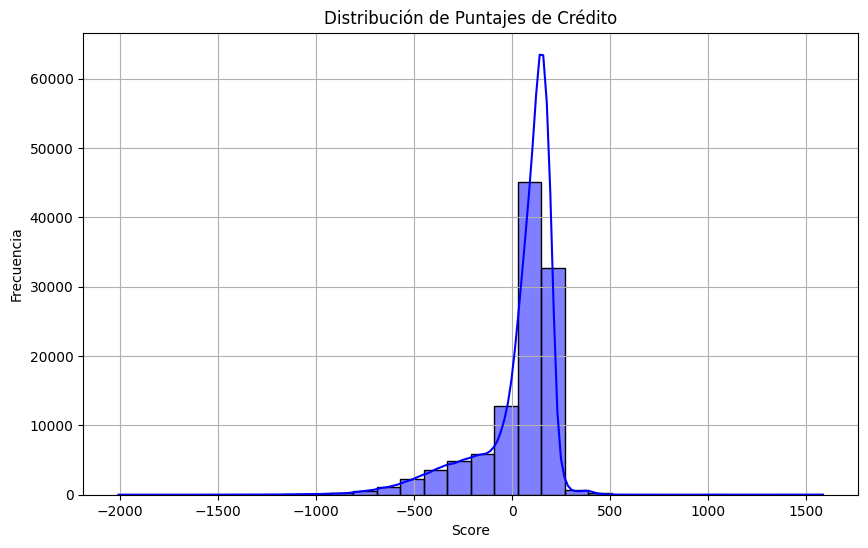

In [17]:
# Visualizar la distribución de los puntajes
plt.figure(figsize=(10, 6))
sns.histplot(y_scores, bins=30, kde=True, color='blue')
plt.title("Distribución de Puntajes de Crédito")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()


In [19]:
import joblib
from tensorflow.keras.models import save_model

# Guardar el modelo entrenado
save_model(model, os.path.join('..', 'models', 'loan_model.h5'))

# Guardar el preprocesador
joblib.dump(preprocessor, os.path.join('..', 'models', 'preprocessor.pkl'))


C:\Users\alexg\AppData\Local\Temp\ipykernel_26460\2176741268.py:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, os.path.join('..', 'models', 'loan_model.h5'))


['..\\models\\preprocessor.pkl']